# 自动带钢异常检测 -- CNN
#### 该项目旨在自动检测热轧钢带的表面缺陷，例如轧痕、斑块、裂纹、坑洼表面、夹杂物和划痕（如下图所示）。该数据库包含 1800 张灰度图像，六种不同的表面缺陷各有 300 个样本。

## 1. 导入相关依赖

In [25]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt 
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.datasets import load_files
# from tensorflow.keras.utils import np_utils
import np_utils
from keras.preprocessing.image import array_to_img, img_to_array, load_img

## 2. 导入数据集

In [26]:
# 定义路径
train_dir = '../NEU Metal Surface Defects Data/train'
val_dir = '../NEU Metal Surface Defects Data/valid'
test_dir = '../NEU Metal Surface Defects Data/test'

# 检查并打印路径下的目录和文件
def list_directory_contents(path, description):
    try:
        contents = os.listdir(path)
        print(f"{description}: {contents}")
    except FileNotFoundError:
        print(f"Error: {path} not found.")
    except NotADirectoryError:
        print(f"Error: {path} is not a directory.")
    except PermissionError:
        print(f"Error: Permission denied for {path}.")

base_dir = '../NEU Metal Surface Defects Data'
list_directory_contents(base_dir, "Path")
list_directory_contents(train_dir, "Train")
list_directory_contents(test_dir, "Test")
list_directory_contents(val_dir, "Validation")

Path: ['valid', 'test', 'train']
Train: ['Inclusion', 'Patches', 'Rolled', 'Pitted', 'Scratches', 'Crazing']
Test: ['Inclusion', 'Patches', 'Rolled', 'Pitted', 'Scratches', 'Crazing']
Validation: ['Inclusion', 'Patches', 'Rolled', 'Pitted', 'Scratches', 'Crazing']


#### For each Class, the Training Data includes 276 Images, Validation & Test sets have 12 images each.

In [27]:
print("Inclusion Defect")
print("Training Images:",len(os.listdir(train_dir+'/'+'Inclusion')))
print("Testing Images:",len(os.listdir(test_dir+'/'+'Inclusion')))
print("Validation Images:",len(os.listdir(val_dir+'/'+'Inclusion')))

Inclusion Defect
Training Images: 276
Testing Images: 12
Validation Images: 12


## 3. 数据增强等预处理

In [28]:
# Rescaling all Images by 1./255
train_datagen = ImageDataGenerator(
    rescale=1. / 255,          # 将像素值从 0-255 缩放到 0-1，以标准化图像数据
    shear_range=0.2,           # 随机应用剪切变换，范围为 20%
    zoom_range=0.2,            # 随机应用缩放变换，范围为 20%
    horizontal_flip=True       # 随机水平翻转图像，用于增加数据多样性
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Training images are put in batches of 10
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(200, 200),
        batch_size=10,
        class_mode='categorical')

# Validation images are put in batches of 10
validation_generator = test_datagen.flow_from_directory(
        val_dir,
        target_size=(200, 200),
        batch_size=10,
        class_mode='categorical')

Found 1656 images belonging to 6 classes.
Found 72 images belonging to 6 classes.


#### 早停--max = 98%

In [29]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy') > 0.98 ):
            print("\nReached 98% accuracy so cancelling training!")
            self.model.stop_training = True 

## 4. 定义核心网络架构

In [30]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (2,2), activation='relu', input_shape=(200, 200, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (2,2), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (2,2), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(6, activation='softmax')
])
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 199, 199, 32)   │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 99, 99, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 98, 98, 64)     │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 49, 49, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 48, 48, 128)    │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 73728)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │    18,874,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,917,734 (72.17 MB)

 Trainable params: 18,917,734 (72.17 MB)

 Non-trainable params: 0 (0.00 B)

In [31]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy',"recall"])

In [32]:
# tf.keras.utils.plot_model(
#     model,
#     to_file='cnn_architecture.png',
#     show_shapes=True)

## 5. 训练模型

In [33]:
callbacks = myCallback()
history = model.fit(train_generator,
        batch_size = 32,
        epochs=20,
        validation_data=validation_generator,
        callbacks=[callbacks],
        verbose=1, shuffle=True)

Epoch 1/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 13s 73ms/step - accuracy: 0.2389 - loss: 2.6695 - recall: 0.0265 - val_accuracy: 0.7083 - val_loss: 1.2291 - val_recall: 0.1111
Epoch 2/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 12s 70ms/step - accuracy: 0.4994 - loss: 1.3034 - recall: 0.2280 - val_accuracy: 0.6944 - val_loss: 0.7505 - val_recall: 0.6111
Epoch 3/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 12s 72ms/step - accuracy: 0.6508 - loss: 0.9631 - recall: 0.5192 - val_accuracy: 0.7917 - val_loss: 0.5704 - val_recall: 0.7500
Epoch 4/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 12s 72ms/step - accuracy: 0.7145 - loss: 0.7592 - recall: 0.6504 - val_accuracy: 0.6528 - val_loss: 1.1576 - val_recall: 0.5833
Epoch 5/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 12s 71ms/step - accuracy: 0.7844 - loss: 0.6638 - recall: 0.7253 - val_accuracy: 0.9583 - val_loss: 0.1434 - val_recall: 0.9444
Epoch 6/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 12s 71ms/step - accuracy: 0.7864 - loss: 0.5714 - recall: 0.7426 - val_accuracy: 1.0000 - val_loss: 0.0821 - val_recall:

## 6. 可视化结果展示

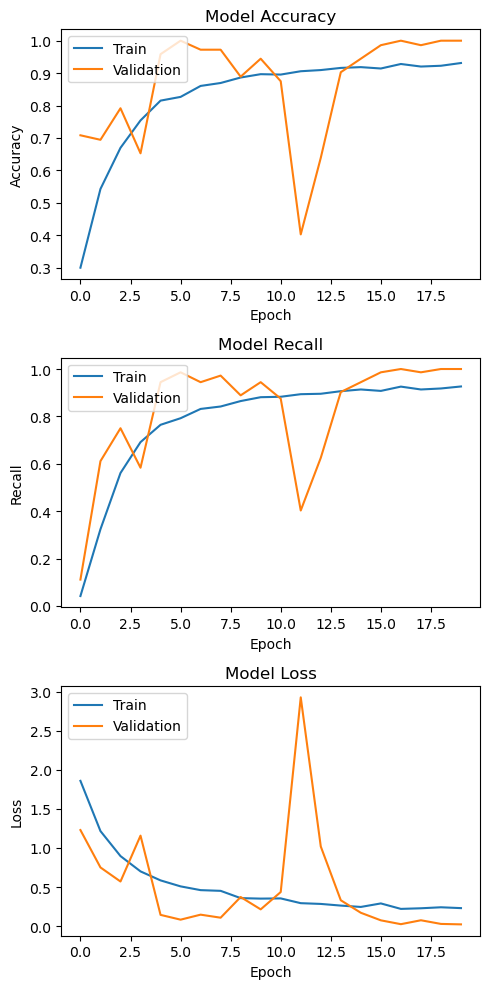

In [34]:


# 设置图像的长和宽为 5 和 10
plt.figure(figsize=(5, 10))

# 绘制准确率
plt.subplot(311)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# 绘制召回率
plt.subplot(312)
plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.title('Model Recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')


# 绘制损失
plt.subplot(313)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


## 7. 测试集预测展示

In [35]:
# Loading file names & their respective target labels into numpy array
def load_dataset(path):
    data = load_files(path)
    files = np.array(data['filenames'])
    targets = np.array(data['target'])
    target_labels = np.array(data['target_names'])
    return files,targets,target_labels
x_test, y_test,target_labels = load_dataset(test_dir)
no_of_classes = len(np.unique(y_test))
no_of_classes

6

In [36]:
# y_test = np_utils.to_categorical(y_test,no_of_classes)
from keras.utils import to_categorical
# print(y_test)
y_test = to_categorical(y_test, num_classes=no_of_classes)

# print(y_test.shape)
# print(y_test)

In [37]:
def convert_image_to_array(files):
    images_as_array=[]
    for file in files:
        # Convert to Numpy Array
        images_as_array.append(img_to_array(load_img(file)))
    return images_as_array

x_test = np.array(convert_image_to_array(x_test))
print('Test set shape : ',x_test.shape)

Test set shape :  (72, 200, 200, 3)


In [38]:
x_test = x_test.astype('float32')/255
x_test

array([[[[0.8039216 , 0.8039216 , 0.8039216 ],
         [0.75686276, 0.75686276, 0.75686276],
         [0.6156863 , 0.6156863 , 0.6156863 ],
         ...,
         [0.32156864, 0.32156864, 0.32156864],
         [0.29411766, 0.29411766, 0.29411766],
         [0.3254902 , 0.3254902 , 0.3254902 ]],

        [[0.7607843 , 0.7607843 , 0.7607843 ],
         [0.7019608 , 0.7019608 , 0.7019608 ],
         [0.6509804 , 0.6509804 , 0.6509804 ],
         ...,
         [0.36078432, 0.36078432, 0.36078432],
         [0.2901961 , 0.2901961 , 0.2901961 ],
         [0.2784314 , 0.2784314 , 0.2784314 ]],

        [[0.7764706 , 0.7764706 , 0.7764706 ],
         [0.7882353 , 0.7882353 , 0.7882353 ],
         [0.7882353 , 0.7882353 , 0.7882353 ],
         ...,
         [0.34509805, 0.34509805, 0.34509805],
         [0.28235295, 0.28235295, 0.28235295],
         [0.2627451 , 0.2627451 , 0.2627451 ]],

        ...,

        [[0.8509804 , 0.8509804 , 0.8509804 ],
         [0.8235294 , 0.8235294 , 0.8235294 ]

## Results of Hot-Rolled Steel Strips Surface Defect Detection

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
[[5.66150775e-05 3.79301126e-24 9.99943376e-01 4.92372532e-11
  4.51317101e-16 7.70629600e-13]
 [2.58230109e-04 2.88161391e-23 9.99741793e-01 3.57224139e-10
  6.98507520e-16 8.71889436e-11]
 [6.08985029e-05 3.16998892e-04 7.18450153e-08 2.20893696e-02
  9.77517843e-01 1.48721456e-05]
 [1.03258131e-11 9.94782865e-01 5.31438726e-10 2.65193055e-03
  8.65651870e-08 2.56506610e-03]
 [1.33706294e-06 6.13910477e-26 9.99998689e-01 7.31748107e-10
  2.55912587e-22 2.26881881e-13]
 [5.67594398e-05 1.00249781e-06 1.97967776e-09 1.14794748e-04
  9.99827385e-01 5.12695877e-08]
 [9.99992371e-01 3.27318034e-27 7.58024771e-06 3.57807628e-09
  2.82200842e-15 3.36799226e-16]
 [6.02265005e-04 3.51457893e-05 9.25327242e-07 3.28731316e-04
  9.98998702e-01 3.43062093e-05]
 [1.02582149e-07 3.97372461e-29 9.99999881e-01 4.21914050e-13
  3.21105440e-22 1.91360625e-17]
 [2.61682196e-08 7.45860405e-07 8.78339790e-07 6.85081659e-06
  2.91025160e-09 9.99991536e-01]
 [3.49376774

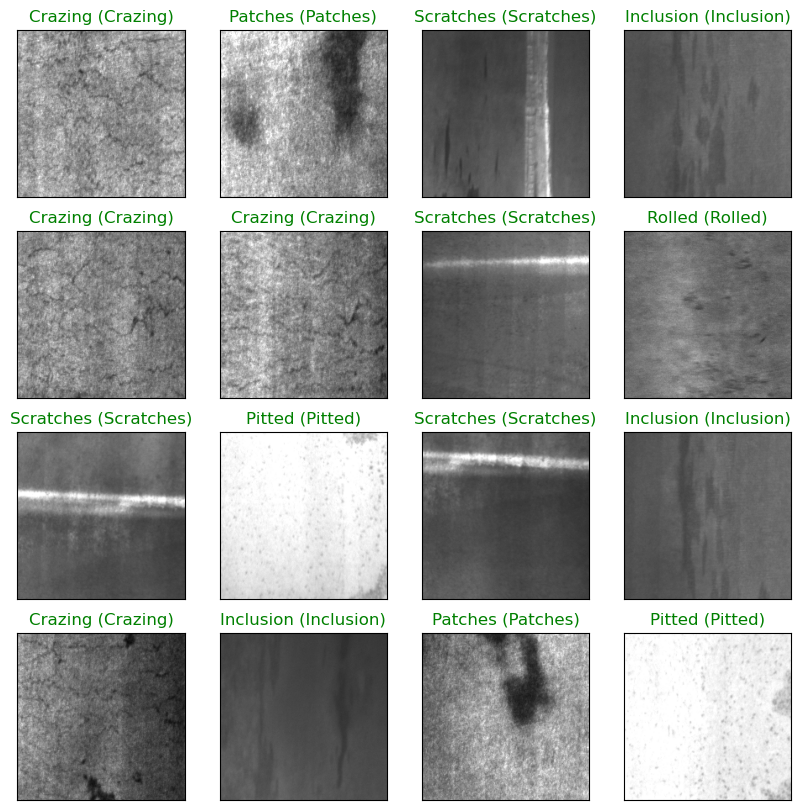

In [39]:
# Plotting Random Sample of test images, their predicted labels, and ground truth
y_pred = model.predict(x_test)
print(y_pred)
fig = plt.figure(figsize=(10, 10))
for i, idx in enumerate(np.random.choice(x_test.shape[0], size=16, replace=False)):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test[idx]))
    pred_idx = np.argmax(y_pred[idx])
    true_idx = np.argmax(y_test[idx])
    ax.set_title("{} ({})".format(target_labels[pred_idx], target_labels[true_idx]),
                 color=("green" if pred_idx == true_idx else "red"))